# Fifth Classifier

No age or image data, since those seem to be the explanatory variables the classifiers love the most.

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}
image_cols = {x for x in df.columns if x.find('image') > -1}
age_cols = {x for x in df.columns if x.find('age') > -1} | set(['flag_Juvenile'])

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - age_cols - image_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 90)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.674921568627451


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.200000,0.859649,0.941176,0.166667,0.633987,"[0.0, 0.0392156862745, 0.0588235294118, 0.0588...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.7, 0.636915099793, 0.51, 0.47, 0.41, 0.3, 0..."
1,0.000000,0.807018,0.901961,0.000000,0.681373,"[0.0, 0.0980392156863, 0.0980392156863, 0.1372...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.64965161559, 0.649651615594, 0.5, 0.38, 0.3..."
2,0.133333,0.771930,0.843137,0.166667,0.397059,"[0.0, 0.137254901961, 0.176470588235, 0.215686...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.63460849754, 0.634608497544, 0.36, 0.33, 0...."
3,0.066667,0.508772,0.549020,0.166667,0.375817,"[0.0, 0.43137254902, 0.450980392157, 0.4509803...","[0.0, 0.166666666667, 0.166666666667, 0.5, 0.5...","[1.70661857164, 0.70661857164, 0.675410605704,..."
4,0.074074,0.561404,0.607843,0.166667,0.303922,"[0.0, 0.392156862745, 0.392156862745, 0.411764...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.71227595998, 0.712275959984, 0.68, 0.237523..."
5,0.363636,0.877193,0.941176,0.333333,0.898693,"[0.0, 0.0588235294118, 0.0588235294118, 0.0784...","[0.166666666667, 0.166666666667, 0.33333333333...","[0.74, 0.645088546163, 0.51, 0.38, 0.26, 0.21,..."
6,0.000000,0.842105,0.941176,0.000000,0.725490,"[0.0, 0.0392156862745, 0.0588235294118, 0.0784...","[0.0, 0.0, 0.0, 0.166666666667, 0.333333333333...","[1.64007053358, 0.640070533576, 0.53, 0.41, 0...."
7,0.222222,0.877193,0.960784,0.166667,0.772876,"[0.0, 0.0392156862745, 0.0392156862745, 0.0588...","[0.166666666667, 0.166666666667, 0.33333333333...","[0.76, 0.640254202141, 0.44, 0.29, 0.26, 0.25,..."
8,0.000000,0.875000,0.980000,0.000000,0.980000,"[0.0, 0.02, 0.02, 0.16, 0.2, 0.24, 0.28, 0.3, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.63, 0.63, 0.474783330496, 0.26, 0.25, 0.21,..."
9,0.833333,0.963636,0.960000,1.000000,0.980000,"[0.0, 0.04, 0.08, 0.12, 0.16, 0.36, 0.52, 0.56...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.51045706357, 0.510457063565, 0.42, 0.35, 0...."


In [7]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

n_ads                             0.068029
missing_price_per_min:count       0.064786
missing_price:count               0.058733
missing_duration_in_mins:count    0.058097
n_incall                          0.052667
location_tree_length              0.044412
flag_Foreign Providers            0.043955
flag_Traveling                    0.040833
n_distinct_locations              0.038509
n_incall_and_outcall              0.037572
n_cooccurring_phones              0.032164
ethnicity_White                   0.032067
n_outcall                         0.031207
ethnicity_Latina                  0.026496
ethnicity_Ebony                   0.023684
ethnicity_Rican                   0.021559
ethnicity_Indian                  0.017488
ethnicity_Asian                   0.015942
missing_price:std                 0.015151
missing_price_per_min:std         0.015037
dtype: float64

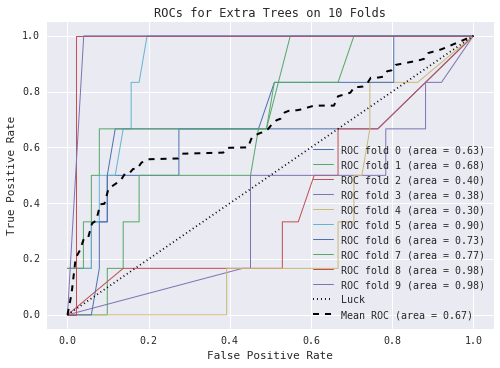

In [8]:
draw_rocs(etc_metrics, 'Extra Trees')

### Random Forest

In [9]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.6560915032679738


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.222222,0.877193,0.960784,0.166667,0.619281,"[0.0, 0.0392156862745, 0.0588235294118, 0.0588...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.64, 0.636915099793, 0.46, 0.43, 0.22, 0.21,..."
1,0.000000,0.807018,0.901961,0.000000,0.679739,"[0.0, 0.0980392156863, 0.0980392156863, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.64965161559, 0.649651615594, 0.39, 0.34, 0...."
2,0.133333,0.771930,0.843137,0.166667,0.426471,"[0.0, 0.137254901961, 0.196078431373, 0.235294...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.63460849754, 0.634608497544, 0.37, 0.31, 0...."
3,0.066667,0.508772,0.549020,0.166667,0.354575,"[0.0, 0.450980392157, 0.450980392157, 0.470588...","[0.0, 0.166666666667, 0.333333333333, 0.333333...","[1.70661857164, 0.70661857164, 0.35, 0.3304643..."
4,0.000000,0.543860,0.607843,0.000000,0.372549,"[0.0, 0.392156862745, 0.392156862745, 0.411764...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.71227595998, 0.712275959984, 0.45, 0.251425..."
5,0.000000,0.842105,0.941176,0.000000,0.834967,"[0.0, 0.0588235294118, 0.0588235294118, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.64508854616, 0.645088546163, 0.45, 0.35, 0...."
6,0.000000,0.859649,0.960784,0.000000,0.665033,"[0.0, 0.0392156862745, 0.078431372549, 0.07843...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.64007053358, 0.640070533576, 0.4, 0.38, 0.2..."
7,0.222222,0.877193,0.960784,0.166667,0.668301,"[0.0, 0.0392156862745, 0.0392156862745, 0.2352...","[0.0, 0.0, 0.333333333333, 0.333333333333, 0.3...","[1.64025420214, 0.640254202141, 0.41, 0.19, 0...."
8,0.000000,0.892857,1.000000,0.000000,0.980000,"[0.0, 0.02, 0.02, 0.16, 0.22, 0.26, 0.3, 0.36,...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.5, 0.5, 0.474783330496, 0.24, 0.23, 0.21, 0..."
9,0.769231,0.945455,0.940000,1.000000,0.960000,"[0.0, 0.02, 0.06, 0.26, 0.3, 0.38, 0.42, 0.44,...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.56, 0.56, 0.510457063565, 0.19, 0.16, 0.08,..."


In [10]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_duration_in_mins:count    0.095945
missing_price:count               0.089282
missing_price_per_min:count       0.088201
n_ads                             0.082127
flag_Foreign Providers            0.051977
location_tree_length              0.043452
n_incall                          0.041181
n_incall_and_outcall              0.036762
flag_Traveling                    0.036391
n_distinct_locations              0.034524
ethnicity_White                   0.028986
n_cooccurring_phones              0.028976
n_outcall                         0.028676
ethnicity_Latina                  0.025580
ethnicity_Ebony                   0.019289
ethnicity_Asian                   0.017481
ethnicity_Rican                   0.017090
ethnicity_Indian                  0.016629
flag_Multiple Girls               0.016076
missing_price:std                 0.013299
dtype: float64

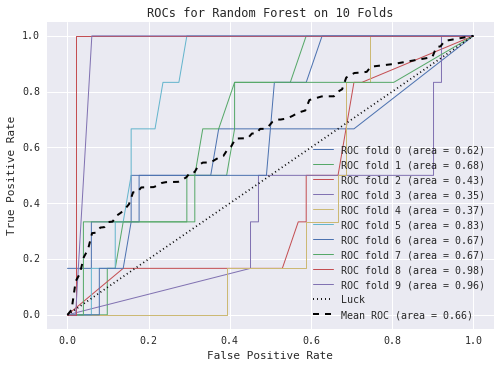

In [11]:
draw_rocs(rf_metrics, 'Random Forest')